In [1]:
import pandas as pd
import seaborn as sns
import re
import time
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS 

In [2]:
# notification
from subprocess import call

def notify(content=""):
    cmd = 'display notification \"' + \
        "Your training is done! Time: "+content + '\" with title \"Jupyter-notebook\"'
    call(["osascript", "-e", cmd])

In [3]:
df1 = pd.read_csv('../data/train_new.csv')

In [4]:
df2 = pd.read_csv('../data/dev_new.csv')

In [30]:
df1

,user_id,n_reviews,rating_mean,n_days,n_reviews_per_day,max_per_day,ex_id,prod_id,rating,label,date,review
0,923,26,4.5,17.0,1.529412,3.0,0,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...
1,923,26,4.5,17.0,1.529412,3.0,5992,19,5.0,1,2014-01-14,The restaurant is on the ground floor of a typ...
2,923,26,4.5,17.0,1.529412,3.0,12853,40,4.0,1,2014-05-30,Really nice mousaka and lovely décor inside. A...
3,923,26,4.5,17.0,1.529412,3.0,29654,79,3.0,1,2014-03-30,We ate at the Blue Ribbon with colleagues. The...
4,923,26,4.5,17.0,1.529412,3.0,30833,81,4.0,1,2014-09-28,I loved the antibiotic- and hormone-free chick...
...,...,...,...,...,...,...,...,...,...,...,...,...
250869,161142,1,4.0,1.0,1.000000,1.0,358942,349,4.0,0,2014-02-20,Giving the 4 stars simply because it's a pizza...
250870,161143,1,5.0,1.0,1.000000,1.0,358943,349,5.0,0,2014-02-19,get the fried brussel sprouts. get the emily p...
250871,161144,1,5.0,1.0,1.000000,1.0,358947,349,5.0,0,2014-02-11,The food was perfect. The wine was perfect. Th...
250872,161145,1,5.0,1.0,1.000000,1.0,358949,349,5.0,0,2014-02-09,Came here for Sunday brunch. Everything we tas...


In [31]:
df1.label.shape

(250874,)

In [28]:
df2

,user_id,n_reviews,rating_mean,n_days,n_reviews_per_day,max_per_day,ex_id,prod_id,rating,label,date,review
0,923,26,4.5,17.0,1.529412,3.0,90566,256,5.0,1,2013-12-08,"This is the place to go if u love tofu, kimchi..."
1,923,26,4.5,17.0,1.529412,3.0,297788,778,5.0,1,2014-02-12,"The place is hard to find and out of the way, ..."
2,923,26,4.5,17.0,1.529412,3.0,342904,919,5.0,1,2014-02-02,Bistango is a casual trattoria that hits all t...
3,923,26,4.5,17.0,1.529412,3.0,346277,247,1.0,1,2014-07-07,"Their ramen is very mediocre, we are living in..."
4,923,26,4.5,17.0,1.529412,3.0,353769,908,4.0,1,2014-06-12,Great dinner with great service. Party of elev...
...,...,...,...,...,...,...,...,...,...,...,...,...
23523,156017,1,3.0,1.0,1.000000,1.0,341975,898,5.0,0,2011-05-07,A hidden gem. Act like a wiseguy and let the ...
23524,156147,1,5.0,1.0,1.000000,1.0,342271,503,5.0,0,2014-03-02,So i bailed on my friends who were at some hor...
23525,156457,1,5.0,1.0,1.000000,1.0,344536,869,4.0,0,2012-10-13,My friend and I stopped in here for a quick lu...
23526,156586,1,5.0,1.0,1.000000,1.0,343524,726,4.0,0,2013-10-17,"Every time I've eaten here, the pasta is quite..."


In [4]:
# df_all=pd.concat([df1,df2],axis=0)
# df_all

,ex_id,user_id,prod_id,rating,label,date,review
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...
1,1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...
2,2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...
3,3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...
4,4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...
...,...,...,...,...,...,...,...
35913,358855,161115,349,3.0,0,2014-12-15,"Okay, so I gotta repeat the chorus here and st..."
35914,358859,161116,349,2.0,0,2014-12-10,"The pizza is delicious, but it's SO loud here,..."
35915,358884,161125,349,5.0,0,2014-09-05,Emily has hands down the best pizza I've had i...
35916,358894,1423,349,5.0,0,2014-07-13,I'm not entirely sure who came up with the nam...


In [5]:
# normalize label
df1.label=df1.label.replace(0,-1)
df2.label=df2.label.replace(0,-1)
df2.label

0        1
1        1
2        1
3        1
4        1
        ..
23523   -1
23524   -1
23525   -1
23526   -1
23527   -1
Name: label, Length: 23528, dtype: int64

In [6]:
# resampling for balanced dataset
print(df1['label'].value_counts())
print(df1['label'].value_counts(1))
n_neg,n_pos=df1['label'].value_counts()

df1_neg=df1.loc[df1['label'] == -1]
df1_pos=df1.loc[df1['label'] == 1]

# downsampling
df1_neg_sample=df1_neg.sample(n=n_pos)
df1_downsample=pd.concat([df1_neg_sample,df1_pos],axis=0)

# upsampling
df1_pos_dup=df1_pos
for i in range(n_neg//n_pos-1):
    df1_pos_dup=pd.concat([df1_pos,df1_pos_dup],axis=0)
df1_upsample=pd.concat([df1_neg,df1_pos_dup],axis=0)

# randomize
sampler = np.random.permutation(df1_downsample.shape[0])
df1_downsample=df1_downsample.take(sampler)

sampler = np.random.permutation(df1_upsample.shape[0])
df1_upsample=df1_upsample.take(sampler)
df1_upsample

-1    225055
 1     25819
Name: label, dtype: int64
-1    0.897084
 1    0.102916
Name: label, dtype: float64


,user_id,n_reviews,rating_mean,n_days,n_reviews_per_day,max_per_day,ex_id,prod_id,rating,label,date,review
111942,32881,2,4.000000,2.0,1.000000,1.0,42870,100,4.0,-1,2013-01-26,I went here for brunch and I had a nice experi...
134309,45865,2,4.000000,1.0,2.000000,2.0,64351,171,5.0,1,2014-01-22,Unbelievably great! Very very small but that n...
168130,69699,1,5.000000,1.0,1.000000,1.0,112047,714,5.0,-1,2014-10-09,Wonderful restaurant... Nice blend of spices a...
187749,86910,2,4.000000,2.0,1.000000,1.0,150769,689,4.0,-1,2010-07-26,I remember always passing on the tuna salad sa...
230922,134309,1,2.000000,1.0,1.000000,1.0,272667,711,2.0,1,2013-04-23,I was very excited when I found out about this...
...,...,...,...,...,...,...,...,...,...,...,...,...
193849,92901,1,2.000000,1.0,1.000000,1.0,164658,465,2.0,1,2014-10-03,"A 30 minute wait at 3pm, a twosome sat at the ..."
92288,24377,1,4.000000,1.0,1.000000,1.0,29679,79,4.0,1,2011-05-18,"So yummy. Great service, great food, and the w..."
226647,129041,1,5.000000,1.0,1.000000,1.0,256721,668,5.0,1,2014-08-11,This is the place to eat on Manhattan! We wher...
107667,30723,4,4.250000,3.0,1.333333,2.0,79975,220,5.0,-1,2011-01-29,I was a bit skeptical when I told my friend I ...


In [8]:
# structural features
df1_=df1[['n_reviews','rating_mean','n_days','n_reviews_per_day','max_per_day','rating']]
df1_

,n_reviews,rating_mean,n_days,n_reviews_per_day,max_per_day,rating
0,26,4.5,17.0,1.529412,3.0,3.0
1,26,4.5,17.0,1.529412,3.0,5.0
2,26,4.5,17.0,1.529412,3.0,4.0
3,26,4.5,17.0,1.529412,3.0,3.0
4,26,4.5,17.0,1.529412,3.0,4.0
...,...,...,...,...,...,...
250869,1,4.0,1.0,1.000000,1.0,4.0
250870,1,5.0,1.0,1.000000,1.0,5.0
250871,1,5.0,1.0,1.000000,1.0,5.0
250872,1,5.0,1.0,1.000000,1.0,5.0


In [9]:
scaler = MinMaxScaler()
scaler.fit(df1_)
print(scaler.data_max_)
def get_features(df):
    df=df[['n_reviews','rating_mean','n_days','n_reviews_per_day','max_per_day','rating']]
    return scaler.transform(df)
feat_train=get_features(df1)
feat_train_downsample=get_features(df1_downsample)
feat_train_upsample=get_features(df1_upsample)
feat_test=get_features(df2)

[121.   5. 121.  13.  19.   5.]


In [6]:
# onehot encoding for structural features
# df1_=df1[['user_id','prod_id','rating','date']]
# enc=OneHotEncoder(handle_unknown='ignore')
# enc.fit(df1_)
# print(enc.get_params())
# print(len(enc.get_feature_names(['user_id','prod_id','rating','date'])))
# # print(np.array(enc.categories_).shape)
# def get_features(df):
#     df=df[['user_id','prod_id','rating','date']]
#     return enc.transform(df).toarray()

{'categories': 'auto', 'drop': None, 'dtype': <class 'numpy.float64'>, 'handle_unknown': 'ignore', 'sparse': True}
129980


In [7]:
# onehot_train=get_features(df1)
# onehot_train_downsample=get_features(df1_downsample)
# onehot_train_upsample=get_features(df1_upsample)
# onehot_test=get_features(df2)
# notify()

In [20]:
# print(onehot_train.shape)
# # print(len(enc.get_feature_names(['user_id'])))
# print(np.array(enc.categories_[0]).shape)
# print(np.array(enc.categories_[1]).shape)
# print(np.array(enc.categories_[2]).shape)
# print(np.array(enc.categories_[3]).shape)

(250874, 129980)
(125679,)
(923,)
(5,)
(3373,)


In [7]:
# stopwords from nltk
stopwords1=set(stopwords.words('english'))|set([''])
# stopwords from wordcloud
stopwords2 = set(STOPWORDS)
add_stopword=set(['','aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'])
stopwords2=stopwords2|add_stopword

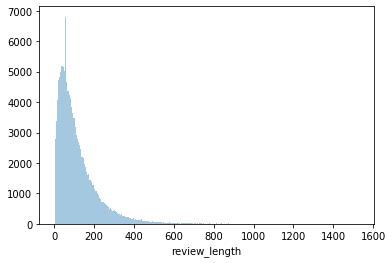

In [56]:
# statistics
# df1['review_length'] = df1['review'].apply(lambda x: len(x.split()))
# df1['review_length_nonstopwords'] = df1['review'].apply(
#     lambda x: len([word for word in (re.sub(r'[^\w]', ' ', x)).lower().split() if word not in stopwords]))
# sns.distplot(df1['review_length'], kde=False, bins=500)

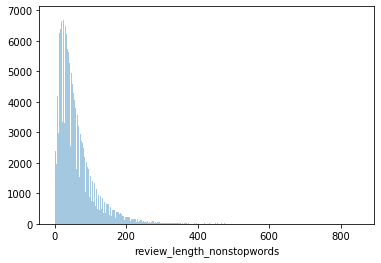

In [57]:
# sns.distplot(df1['review_length_nonstopwords'], kde=False, bins=500)

In [8]:
# text preprocessing
def preprocessing(df):
    texts=[]
    chars=re.compile(r'[0-9]+')
    symbols = '${}()[].,:;+-*/&|<>=~"\'@#$%^`~!?_'
    for k, v in df.review.items():
        v=chars.sub('', v)
        v = v.split(' ')
        words = map(lambda Element: Element.translate(str.maketrans("", "", symbols)).strip().lower(), v)
        v=' '.join(words).strip()
        texts.append(v)
    return texts

In [12]:
review_train=preprocessing(df1)

In [9]:
review_train_downsample=preprocessing(df1_downsample)

In [14]:
review_train_upsample=preprocessing(df1_upsample)

In [10]:
review_test=preprocessing(df2)

In [34]:
# for v in review_train[:3]:
#     print(v)
#     for i in range(10):
#         if str(i) in v:
#             print('has number')

the food at snack is a selection of popular greek dishes the appetizer tray is good as is the greek salad we were underwhelmed with the main courses there are  tables here so its sometimes hard to get seated
this little place in soho is wonderful i had a lamb sandwich and a glass of wine the price shocked me for how small the serving was but then again this is soho the staff can be a little snotty and rude but the food is great just dont expect worldclass service
ordered lunch for  from snack last friday on time nothing missing and the food was great i have added it to the regular company lunch list as everyone enjoyed their meal


In [23]:
# get features from the whole training set
vectorizer_train=TfidfVectorizer(stop_words=stopwords1,ngram_range=(1,2),min_df=30)
review_vec_train = vectorizer_train.fit_transform(review_train)
notify()

In [24]:
print(review_vec_train.shape)
print(vectorizer_train.get_feature_names()[:50])

(250874, 71069)
['aaron', 'aback', 'abalone', 'abandon', 'abandoned', 'abc', 'abc carpet', 'abc home', 'abc kitchen', 'abeille', 'ability', 'abit', 'abita', 'able', 'able accommodate', 'able bring', 'able catch', 'able choose', 'able come', 'able eat', 'able enjoy', 'able find', 'able finish', 'able get', 'able give', 'able go', 'able grab', 'able handle', 'able hear', 'able hold', 'able keep', 'able make', 'able move', 'able order', 'able pick', 'able put', 'able sample', 'able say', 'able score', 'able seat', 'able seated', 'able see', 'able share', 'able sit', 'able snag', 'able squeeze', 'able take', 'able talk', 'able taste', 'able tell']


In [25]:
review_vec_train_downsample = vectorizer_train.transform(review_train_downsample)
# review_vec_train_upsample = vectorizer_train.transform(review_train_upsample)
review_vec_test = vectorizer_train.transform(review_test)
# print(review_vec_train_downsample.shape,review_vec_train_upsample.shape,review_vec_test.shape)
notify()

In [26]:
review_vec_train_downsample_dense=review_vec_train_downsample.toarray()
review_vec_test_dense=review_vec_test.toarray()

In [19]:
def print_eval(y,pred):
    print(metrics.classification_report(y, pred))
    print('roc_auc_score: %.2f'%roc_auc_score(y, pred))
    print('average_prediction_score: %.2f'%average_precision_score(y, pred))

In [20]:
def train(X_train,y_train,X_test,y_test):
    clf=MultinomialNB(alpha=0.01)
    clf.fit(X_train, y_train)
    # eval on training set
    predicted_train = clf.predict(X_train)
    print('evaluation on training set')
    print_eval(y_train, predicted_train)

    # eval on validation set
#     X_test=review_vec_test
#     y_test=df2.label
    predicted = clf.predict(X_test)
    print('\nevaluation on validation set')
    print_eval(y_test, predicted)

    print('\nparameters:\n',clf.get_params())
    print('predict probablity:\n',clf.predict_proba(X_test))

In [38]:
# train: unbalanced, textual featuers
X_train=review_vec_train
y_train=df1.label
train(X_train,y_train)

evaluation on training set
              precision    recall  f1-score   support

          -1       0.90      1.00      0.95    225055
           1       0.73      0.03      0.06     25819

    accuracy                           0.90    250874
   macro avg       0.81      0.52      0.50    250874
weighted avg       0.88      0.90      0.86    250874

roc_auc_score: 0.52
average_prediction_score: 0.12

evaluation on validation set
              precision    recall  f1-score   support

          -1       0.90      1.00      0.95     32270
           1       0.35      0.01      0.02      3648

    accuracy                           0.90     35918
   macro avg       0.63      0.50      0.48     35918
weighted avg       0.84      0.90      0.85     35918

roc_auc_score: 0.50
average_prediction_score: 0.10

parameters:
 {'alpha': 0.01, 'class_prior': None, 'fit_prior': True}
predict probablity:
 [[0.91862945 0.08137055]
 [0.98654879 0.01345121]
 [0.95371636 0.04628364]
 ...
 [0.92906278 0.0

In [37]:
# train: balanced, downsampling, textual features
X_train=review_vec_train_downsample
y_train=df1_downsample.label
train(X_train,y_train)

evaluation on training set
              precision    recall  f1-score   support

          -1       0.83      0.81      0.82     25819
           1       0.81      0.84      0.83     25819

    accuracy                           0.82     51638
   macro avg       0.82      0.82      0.82     51638
weighted avg       0.82      0.82      0.82     51638

roc_auc_score: 0.82
average_prediction_score: 0.76

evaluation on validation set
              precision    recall  f1-score   support

          -1       0.94      0.66      0.78     32270
           1       0.18      0.63      0.27      3648

    accuracy                           0.66     35918
   macro avg       0.56      0.65      0.53     35918
weighted avg       0.86      0.66      0.73     35918

roc_auc_score: 0.65
average_prediction_score: 0.15

parameters:
 {'alpha': 0.01, 'class_prior': None, 'fit_prior': True}
predict probablity:
 [[0.55688456 0.44311544]
 [0.87153072 0.12846928]
 [0.68754638 0.31245362]
 ...
 [0.59550645 0.4

In [39]:
# train: balanced, upsampling, textual features
X_train=review_vec_train_upsample
y_train=df1_upsample.label
train(X_train,y_train)

evaluation on training set
              precision    recall  f1-score   support

          -1       0.79      0.78      0.79    225055
           1       0.76      0.78      0.77    206552

    accuracy                           0.78    431607
   macro avg       0.78      0.78      0.78    431607
weighted avg       0.78      0.78      0.78    431607

roc_auc_score: 0.78
average_prediction_score: 0.70

evaluation on validation set
              precision    recall  f1-score   support

          -1       0.93      0.75      0.83     32270
           1       0.20      0.53      0.29      3648

    accuracy                           0.73     35918
   macro avg       0.57      0.64      0.56     35918
weighted avg       0.86      0.73      0.78     35918

roc_auc_score: 0.64
average_prediction_score: 0.15

parameters:
 {'alpha': 0.01, 'class_prior': None, 'fit_prior': True}
predict probablity:
 [[0.57791822 0.42208178]
 [0.89903052 0.10096948]
 [0.71155456 0.28844544]
 ...
 [0.61344254 0.3

In [35]:
# train: balanced, downsampling, textual features,  max_features=10000
X_train=review_vec_train_downsample_dense
X_test=review_vec_test_dense
y_train=df1_downsample.label
y_test=df2.label
train(X_train,y_train,X_test,y_test)

evaluation on training set
              precision    recall  f1-score   support

          -1       0.70      0.67      0.68     25819
           1       0.68      0.71      0.70     25819

    accuracy                           0.69     51638
   macro avg       0.69      0.69      0.69     51638
weighted avg       0.69      0.69      0.69     51638

roc_auc_score: 0.69
average_prediction_score: 0.63

evaluation on validation set
              precision    recall  f1-score   support

          -1       0.97      0.70      0.82     22402
           1       0.09      0.61      0.16      1126

    accuracy                           0.70     23528
   macro avg       0.53      0.66      0.49     23528
weighted avg       0.93      0.70      0.78     23528

roc_auc_score: 0.66
average_prediction_score: 0.08

parameters:
 {'alpha': 0.01, 'class_prior': None, 'fit_prior': True}
predict probablity:
 [[0.70917875 0.29082125]
 [0.62121319 0.37878681]
 [0.62688408 0.37311592]
 ...
 [0.57857279 0.4

In [37]:
# train: balanced, downsampling, textual+user features, max_features=10000
X_train=np.concatenate((feat_train_downsample,review_vec_train_downsample_dense),axis=1)
X_test=np.concatenate((feat_test,review_vec_test_dense),axis=1)
y_train=df1_downsample.label
y_test=df2.label
train(X_train,y_train,X_test,y_test)

evaluation on training set
              precision    recall  f1-score   support

          -1       0.72      0.68      0.70     25819
           1       0.69      0.74      0.71     25819

    accuracy                           0.71     51638
   macro avg       0.71      0.71      0.71     51638
weighted avg       0.71      0.71      0.71     51638

roc_auc_score: 0.71
average_prediction_score: 0.64

evaluation on validation set
              precision    recall  f1-score   support

          -1       0.97      0.72      0.83     22402
           1       0.10      0.62      0.17      1126

    accuracy                           0.72     23528
   macro avg       0.54      0.67      0.50     23528
weighted avg       0.93      0.72      0.80     23528

roc_auc_score: 0.67
average_prediction_score: 0.08

parameters:
 {'alpha': 0.01, 'class_prior': None, 'fit_prior': True}
predict probablity:
 [[0.79202957 0.20797043]
 [0.72602788 0.27397212]
 [0.72498662 0.27501338]
 ...
 [0.54941709 0.4

In [22]:
# train: balanced, downsampling, textual features,  max_features=50000
X_train=review_vec_train_downsample_dense
X_test=review_vec_test_dense
y_train=df1_downsample.label
y_test=df2.label
train(X_train,y_train,X_test,y_test)

evaluation on training set
              precision    recall  f1-score   support

          -1       0.80      0.77      0.79     25819
           1       0.78      0.81      0.79     25819

    accuracy                           0.79     51638
   macro avg       0.79      0.79      0.79     51638
weighted avg       0.79      0.79      0.79     51638

roc_auc_score: 0.79
average_prediction_score: 0.73

evaluation on validation set
              precision    recall  f1-score   support

          -1       0.97      0.72      0.83     22402
           1       0.09      0.58      0.16      1126

    accuracy                           0.71     23528
   macro avg       0.53      0.65      0.49     23528
weighted avg       0.93      0.71      0.79     23528

roc_auc_score: 0.65
average_prediction_score: 0.07

parameters:
 {'alpha': 0.01, 'class_prior': None, 'fit_prior': True}
predict probablity:
 [[0.79465785 0.20534215]
 [0.81131118 0.18868882]
 [0.6429318  0.3570682 ]
 ...
 [0.61750226 0.3

In [ ]:
# train: balanced, downsampling, textual features
# X_train=review_vec_train_downsample
# X_test=review_vec_test
# y_train=df1_downsample.label
# y_test=df2.label
# train(X_train,y_train,X_test,y_test)